<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-X.-Template" data-toc-modified-id="Case-X.-Template-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 2 Model 2. Template</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data-and-preprocessing" data-toc-modified-id="Data-and-preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data and preprocessing</a></span></li><li><span><a href="#Constructing-the-model-and-training-it" data-toc-modified-id="Constructing the model and training it-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Constructing the model and training it</a></span></li><li><span><a href="#Results-and-discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and discussion</a></span></li><li><span><a 
href="#Validation-and-results" data-toc-modified-id="Validation-and-discussion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validation and results</a></span></li><li><span><a
href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 2 Model 2. Template
Mikko Kettunen, Niklas Koro, Sami Tanhua, Jake Pärssinen - Group 2<br>
Last edited: 01.03.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# Background
The aim of this notebook is to create a convolutional neural network which classifies if a patient has pneumonia or not, based on X-ray images taken.

# Data and preprocessing

Imports

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import os

%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
from pylab import *
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import preprocessing

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras.models import Model
#from tensorflow.keras import regularizers
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.applications import VGG19
#from keras.preprocessing import image
#from keras.models import Model
#from keras.layers import Dense, GlobalAveragePooling2D
#from keras import backend as K
#from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\mikko\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'power', 'fft', 'linalg', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


1. Images are in 60/20/20 division for training, testing and validation
<br>
<br>
2. In folders, images are divided into 2 subdirectories as this is a binary classification problem.
<br>
<br>
3. CNN frameworks requires that images have fixed sizes in training. We chose the target size to be 150X150 pixels.
<br>
<br>
4. Different batch sizes were tested, 64 gave the best results. It is commonly suggested that batch size is a power of 2 due to how GPUs are coded. This ables the GPU to distribute the workload better.
<br>
<br>
5. We used ImageDataGenerators, because we have a small database and by creating more images we can increase our model accuracy and evade overfitting.
<br>
<br>
6. Data augmentation also reduces overfitting by creating variations of the images. The values of the augmentetion were default values used in most examples.
<br>
<br>
7. In testing and validation we defined the huffle variable to be false, because otherwise the images are shuffled and the program doesn't know which is the right label.

In [3]:
# Define train/test/validation directories
train_dir = 'Case2_XRay/train'
test_dir = 'Case2_XRay/test'
validation_dir = 'Case2_XRay/validation'

TS = (150, 150) # Image size
BS = 64 # Batch size

# Datagenerators and image augmentation
tg = ImageDataGenerator(rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

devg = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode='binary')

dev_generator = devg.flow_from_directory(
    validation_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode='binary')

test_generator = devg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode='binary')

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


We tested the generator by printing 5 batches of data to check if the generator works so that the inputs and outputs have the same size.

In [5]:
# Test the generator
i = 0
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    i = i + 1
    if i > 5:
        break

data batch shape: (64, 150, 150, 3)
labels batch shape: (64,)
data batch shape: (64, 150, 150, 3)
labels batch shape: (64,)
data batch shape: (64, 150, 150, 3)
labels batch shape: (64,)
data batch shape: (64, 150, 150, 3)
labels batch shape: (64,)
data batch shape: (64, 150, 150, 3)
labels batch shape: (64,)
data batch shape: (64, 150, 150, 3)
labels batch shape: (64,)


We tested that the image is the right size and the augmentation has altered the image in some way.

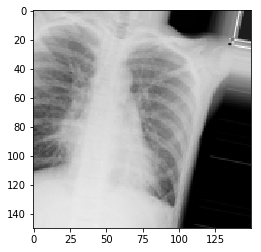

In [14]:
# Check the first image of the batch
imshow(data_batch[0])
show()

# Constructing the model and training it

We wanted to use some model that was specially build for detecting phenomia.<br> We chose to use a model that was used in a research article "An Efficient Deep Learning Approach to Pneumonia Classification in Healthcare".
https://www.hindawi.com/journals/jhe/2019/4180949/ <br>

In [7]:
# Construct Model2
# https://www.hindawi.com/journals/jhe/2019/4180949/
network = models.Sequential()
network.add(layers.Conv2D(32, (3,3), activation = 'relu', 
                          padding = "same",input_shape=(150,150,3)))

network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(62, (3,3), activation = 'relu'))

network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(128, (3,3), activation = 'relu'))

network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(128, (3,3), activation = 'relu'))

network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Flatten())

network.add(Dropout(0.5))

network.add(layers.Dense(512, activation = 'relu'))

network.add(layers.Dense(1, activation = 'sigmoid'))

#network.summary()
tf.get_logger().setLevel('INFO') #Hide tensorflow errors, show only info

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


1. We defined our metrics in advance to avoid increasing indexing in metrics.
<br>
<br>
2. We chosed RMSprop for the optimizer, because it is a popular and widely used optimizer and it worked for us. We used the default values, because they worked well and it's recommended not to alter them much.
<br>
<br>
3. We chose binary_crossentropy for ous loss function, because this is a binary classification problem and we want a probability between 0-1 of the patient to have pneumonia or not.
<br>
<br>
4. The threshold for the SensitivityATSpecificity was chosen by testing which one got the best results in terms of balance between false positive and false negative numbers.

In [80]:
import tensorflow as tf

# Define metrics
my_metrics = [tf.keras.metrics.SensitivityAtSpecificity(0.7)]

# Compile model
network.compile(
    optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    loss = 'binary_crossentropy',
    metrics= my_metrics)

tf.get_logger().setLevel('INFO') #Hide tensorflow errors, show only info

In [81]:
#Save the best weights
filepath="weights6.hdf5"
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_sensitivity_at_specificity_6',  
                            verbose=1, 
                            save_best_only=True, mode='max')

callbacks_list = [checkpoint]

E = 10 # Number of epochs

# Train the model
print('Training ...', end='')
history = network.fit_generator(
    train_generator,
    steps_per_epoch = 20,
    verbose = 1, 
    epochs = E,
    validation_data = dev_generator,
    validation_steps = 40,
    callbacks=callbacks_list)

tf.get_logger().setLevel('INFO') #Hide tensorflow errors, show only info

Training ...Epoch 1/10
19/20 [===========================>..] - ETA: 2s - loss: 0.3857 - sensitivity_at_specificity_6: 0.8715
Epoch 00001: val_sensitivity_at_specificity_6 improved from -inf to 0.96491, saving model to weights6.hdf5
20/20 [==============================] - 85s 4s/step - loss: 0.3858 - sensitivity_at_specificity_6: 0.8776 - val_loss: 0.2962 - val_sensitivity_at_specificity_6: 0.9649
Epoch 2/10
19/20 [===========================>..] - ETA: 2s - loss: 0.2963 - sensitivity_at_specificity_6: 0.9439
Epoch 00002: val_sensitivity_at_specificity_6 improved from 0.96491 to 0.96959, saving model to weights6.hdf5
20/20 [==============================] - 94s 5s/step - loss: 0.2993 - sensitivity_at_specificity_6: 0.9405 - val_loss: 0.2465 - val_sensitivity_at_specificity_6: 0.9696
Epoch 3/10
19/20 [===========================>..] - ETA: 2s - loss: 0.3169 - sensitivity_at_specificity_6: 0.9349
Epoch 00003: val_sensitivity_at_specificity_6 did not improve from 0.96959
20/20 [=========

# Results and discussion

We defined the labels from the training and then tested how the model predicted the outcomes.

In [82]:
labels = dev_generator.classes # Outputs from training
predicted = network.predict_generator(dev_generator).flatten()  # Predicted values

We plotted the ROC curve to determine how good our model performs. As can been seen from the ROC curve, when the true positive rate exceeds a value of 0.8, the false positive rate starts to rise. Analysing the ROC curve, we can come into a conclusion that we can achieve a true positive rate of about 0.90 before our model starts to classify too many cases falsely negative.

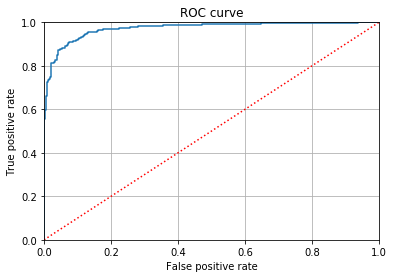

In [83]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)

# Plot ROC curve
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

We printed a confusion matrix and classification report from our results to see how many false negatives,false positives, true negatives and true positives did our model produce. The result show that the model predicts pneumonia cases  better than normal cases.

In [84]:
# Confusion matrix
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.6)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.6).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[307  10]
 [148 707]]
Confusion matrix (medicine way):
[[707 148]
 [ 10 307]]


In [85]:
# Classification report
cr = classification_report(labels, predicted > 0.6, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.67      0.97      0.80       317
Pneumonia (1)       0.99      0.83      0.90       855

     accuracy                           0.87      1172
    macro avg       0.83      0.90      0.85      1172
 weighted avg       0.90      0.87      0.87      1172



# Validation and results

We loaded the best weights used in training and then compiled the model again to be used for validation to see how well the model predicts the outcomes using data it hasn't seen before.

In [86]:
# Load best weights
network.load_weights("weights6.hdf5")

In [87]:
# Compile model again
network.compile(
    optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    loss='binary_crossentropy',
    metrics = my_metrics)

In [88]:
labels = dev_generator.classes # Outputs from training
predicted = network.predict_generator(test_generator).flatten()  # Predicted values using test data

Finally, we calculated all the statistics from the results we got using test data.

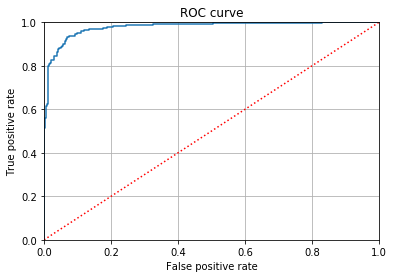

In [89]:
# Calculate ROC curve 
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)

# Plot ROC curve
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

In [90]:
# Confusion matrix from validation
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.6)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.6).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[299  18]
 [ 93 762]]
Confusion matrix (medicine way):
[[762  93]
 [ 18 299]]


In [91]:
# Classification report
cr = classification_report(labels, predicted > 0.6, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.76      0.94      0.84       317
Pneumonia (1)       0.98      0.89      0.93       855

     accuracy                           0.91      1172
    macro avg       0.87      0.92      0.89      1172
 weighted avg       0.92      0.91      0.91      1172



# Conclusions

As you can see from the results, our model predicted the pneumonia cases with a very high accuracy. Pneumonia cases were classified as normal for 23.7% of the cases and normal cases were classified as pneumonia for 2.3% of the cases. The f1 score (which is a good value to use when comparing models) for the pneumonia cases was good and average for the normal cases.
<br>
<br>
When comparing with model 2, the f1-scores were slightly worse in both pneumonia and normal cases.
<br>
<br>
Comparasion with model 3 is done when Sami uploads model 3 with the right file form.